# GNN GAT Explainer

## Graph Data Prep

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
benign = {
    'Tcells':{'up': ['CD3D','LCK','ZAP70'],'down': ['CD19']},
    'Bcells':{'up': ['CD19'],'down': ['CD3D','LCK','ZAP70']},
  #  'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous = {
    'Tcells':{'up': ['CD3D','ZAP70'],'down': ['CD19','LCK']},
    'Bcells':{'up': ['CD19','LCK','CD3D'],'down': ['ZAP70']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous_2 = {
    'Tcells':{'up': ['ZAP70'],'down': ['CD19','CD3D','LCK']},
    'Bcells':{'up': ['CD19','CD3D'],'down': ['LCK','ZAP70']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous_3 = {
    'Tcells':{'up': ['LCK'],'down': ['ZAP70','CD19','CD3D']},
    'Bcells':{'up': ['CD19','ZAP70'],'down': ['LCK','CD3D']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}
graphs = [benign, cancerous, cancerous_2, cancerous_3]

In [3]:
cell_types = ['Tcells','Bcells']
genes = ['CD3D','LCK','ZAP70','CD19'] #only focused on genes present
node_order = genes + [f'CT_{ct}' for ct in cell_types]   # genes first, then CT nodes
gene_mask = torch.tensor([1,1,1,1,0,0], dtype=torch.bool)
N = len(node_order) 

In [4]:
def build_vocab(genes, cell_types):
    toks = genes + [f'CT_{ct}' for ct in cell_types]
    stoi = {t:i for i,t in enumerate(toks)}; itos = {i:t for t,i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(genes, cell_types)
vocab_size = len(stoi)

vocab_size, stoi

(6,
 {'CD3D': 0, 'LCK': 1, 'ZAP70': 2, 'CD19': 3, 'CT_Tcells': 4, 'CT_Bcells': 5})

In [5]:
def make_graph_signed(spec):
    N = len(node_order); 
    A_signed = torch.zeros(N, N)
    def idx(n): 
        return node_order.index(n)
    def add_edge(g, ct, s):
        i, j = idx(g), idx(f"CT_{ct}")
        A_signed[i,j] = s
        A_signed[j,i] = s
    for ct in cell_types:
        for g in spec[ct].get('up', []):   
            add_edge(g, ct, +1)
        for g in spec[ct].get('down', []): 
            add_edge(g, ct, -1)
    # labels for node task (0=T, 1=B) on genes only
    y_node = torch.full((N,), -1, dtype=torch.long)
    X = torch.tensor([stoi[n] for n in node_order], dtype=torch.long)
    
    # per-gene cell-type label: 0=Tcells, 1=Bcells (prefer UP, tie-break T→B, fallback from DOWN)
    y_node = torch.full((N,), -1, dtype=torch.long)
    for g in genes:
        t_up = g in spec['Tcells'].get('up', [])
        b_up = g in spec['Bcells'].get('up', [])
        t_dn = g in spec['Tcells'].get('down', [])
        b_dn = g in spec['Bcells'].get('down', [])
        lab = None
        if t_up and not b_up: 
            lab = 0
        elif b_up and not t_up: 
            lab = 1
        elif t_up and b_up: 
            lab = 0
        else:
            if t_dn and not b_dn: 
                lab = 1
            elif b_dn and not t_dn: 
                lab = 0
        if lab is not None: 
            y_node[idx(g)] = lab
    return X, y_node, A_signed

In [6]:
x_list, y_node_list, a_list = [], [], []
for spec in graphs:
    X_i, y_i, A_i = make_graph_signed(spec)
    x_list.append(X_i); y_node_list.append(y_i); a_list.append(A_i)

x_list, y_node_list, a_list

([tensor([0, 1, 2, 3, 4, 5]),
  tensor([0, 1, 2, 3, 4, 5]),
  tensor([0, 1, 2, 3, 4, 5]),
  tensor([0, 1, 2, 3, 4, 5])],
 [tensor([ 0,  0,  0,  1, -1, -1]),
  tensor([ 0,  1,  0,  1, -1, -1]),
  tensor([ 1, -1,  0,  1, -1, -1]),
  tensor([-1,  0,  1,  1, -1, -1])],
 [tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1.,  1.,  1., -1.,  0.,  0.],
          [-1., -1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1., -1.,  1., -1.,  0.,  0.],
          [ 1.,  1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0., -1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [-1., -1.,  1., -1.,  0.,  0.],
          [ 1., 

**x_tokens** - a list of nodes

Notice that all nodes are present in each of our samples. 

In [7]:
x_tokens = torch.stack(x_list)
x_tokens.size(), x_tokens

(torch.Size([4, 6]),
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-node (gene) gene cell type labels. This uses a balance of the up-regulated and down-regulated genes and flags for each sample. If the gene is more commonly upregulated with B-cells we flag it as `0` and if it's more commonly up-regulated in T-cells we flag it as `1`.  This evaluation is done per sample (seen here as per row). 

The last two columns are embeddings purely for cell type so we flag them as -1 to be masked during training. 

In [8]:
y_node = torch.stack(y_node_list)
y_node.size(), y_node

(torch.Size([4, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 0,  1,  0,  1, -1, -1],
         [ 1, -1,  0,  1, -1, -1],
         [-1,  0,  1,  1, -1, -1]]))

**y_graph** - per-graph (sample) cancer type label. We use `1` for cancerous and `0` for benign

In [9]:
y_graph = torch.tensor([0,1,1,1])  # 0=wild, 1=cancer
y_graph.size(), y_graph

(torch.Size([4]), tensor([0, 1, 1, 1]))

**Graph** 

Since this is a GNN explainer, let's visualize actually how these graphs look. This is in essence the graph the model is looking at and learning how to read so that if it sees a new one, it can predict the properties we are minimizing loss on (cancerous, cell type). 

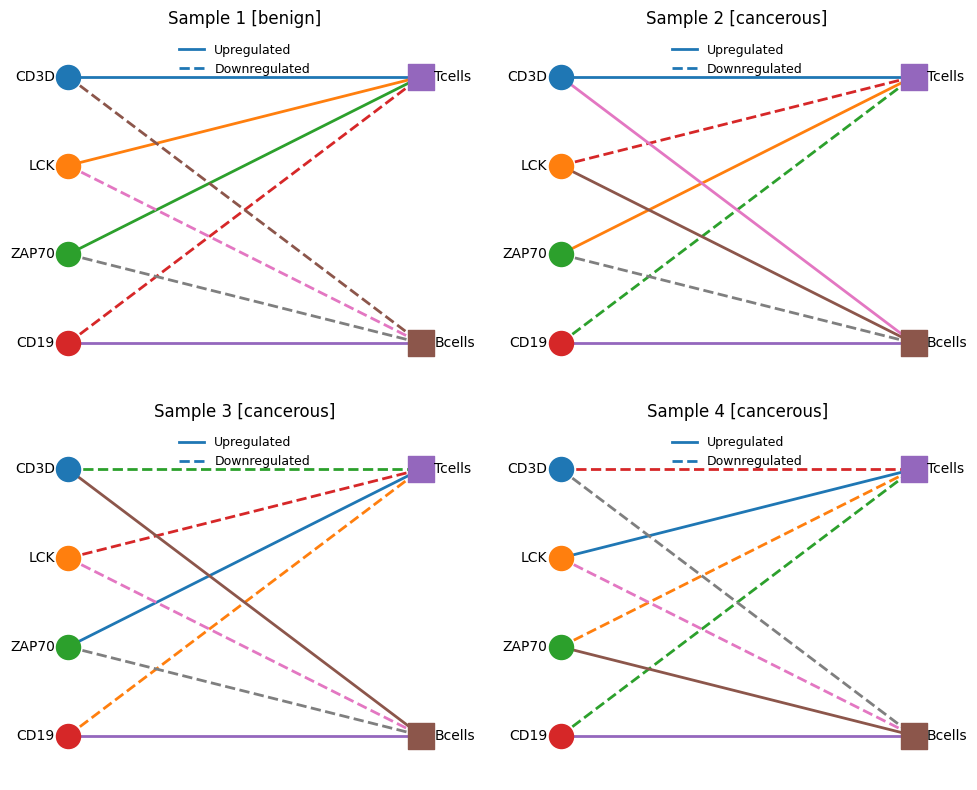

In [10]:
def compute_positions(genes, cell_types):
    # left column (genes), right column (cell types)
    gx, cx = 0.1, 0.9
    gy = list(range(len(genes)-1, -1, -1))  # top-to-bottom
    if len(cell_types) > 1:
        # spread CTs across same vertical span as genes
        span = (len(genes)-1)
        cy = [span * (1 - i/(len(cell_types)-1)) for i in range(len(cell_types))]
    else:
        cy = [(len(genes)-1)/2]
    pos = {g:(gx, gy[i]) for i,g in enumerate(genes)}
    pos.update({f"CT_{ct}":(cx, cy[j]) for j,ct in enumerate(cell_types)})
    return pos

def draw_sample(ax, spec, title, genes, cell_types):
    pos = compute_positions(genes, cell_types)
    # draw nodes
    for i,g in enumerate(genes):
        x,y = pos[g]
        ax.scatter([x],[y], s=300, marker='o', zorder=3)
        ax.text(x-0.03, y, g, va='center', ha='right', fontsize=10)
    for ct in cell_types:
        name = f"CT_{ct}"
        x,y = pos[name]
        ax.scatter([x],[y], s=350, marker='s', zorder=3)
        ax.text(x+0.03, y, ct, va='center', ha='left', fontsize=10)
    # draw edges: solid = upregulated (+1), dashed = downregulated (-1)
    for ct in cell_types:
        ct_name = f"CT_{ct}"
        for g in spec[ct].get('up', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='-', linewidth=2, zorder=2)
        for g in spec[ct].get('down', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='--', linewidth=2, zorder=2)

    # aesthetics
    ax.set_title(title)
    ax.set_xlim(0.0, 1.0)
    ys = list(range(len(genes)))
    ax.set_ylim(-0.5, len(genes)-0.5)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)

    # legend (solid=up, dashed=down)
    from matplotlib.lines import Line2D
    legend_lines = [
        Line2D([0],[0], linestyle='-', linewidth=2, label='Upregulated'),
        Line2D([0],[0], linestyle='--', linewidth=2, label='Downregulated'),
    ]
    ax.legend(handles=legend_lines, loc='upper center', frameon=False, fontsize=9)

# ----- draw all four samples -----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
samples = [
    ('Sample 1 [benign]',    benign),
    ('Sample 2 [cancerous]',    cancerous),
    ('Sample 3 [cancerous]',  cancerous_2),
    ('Sample 4 [cancerous]',  cancerous_3),
]
for ax, (name, spec) in zip(axes.ravel(), samples):
    draw_sample(ax, spec, name, genes, cell_types)

plt.tight_layout()
plt.show()

# Modeling

A machine learning model forward pass now uses the data prep information, runs several layers of linear algebra on it, and then "predicts" the probability of our different tasks, in this case the cell type based on the node and whether a graph is cancerous. When it is noisy (like you will see in this example), this process results in gibberish.  The training process changes the noise to pattern during the "backward pass" as you'll see. We'll show 3 steps that are focused on training:
1. **Data Loading** - this step pulls from the raw data enough examples and batches to complete a forward pass and loss calculation.  If the model is inference only, this step is replaced with taking in the inference input and preparing it similarly as the forward pass. 
2. **Forward Pass** - using the data and the model architecture we run a prediction for the tokens. When training we also compare against the expected to get loss, but in inference, we use the logits to complete the inference task.
3. **Back Propagation, aka Backward Pass & Training** - using differentials we can understand what parameters most drive the difference between forward pass' impact on its prediction versus what is actually right based on the data loading step. We compare this based on the loss function and use the partial derivative gradients to make very minor adjustments to the impactful parameters with the hope it improves future predictions.

After our back prop, we'll show a final **Forward Pass** with the updated weights we did in #3 and then convert those final weights to a **Model Inference**

## Data Loading

To start, we need to get enough data to run the forward and backward passes.  Since our total dataset in a real experiment is likely too big to be held in memory all at once in real practice, we will read just enough file information into memory so that we can run the passes, leaving memory and compute to be used on the passes instead of static data holding. 
To start, we have to identify the batch size and the model context length to determine how much data we need.  Consequently, these dimensions also form 2 of the 3 dimensions in the initial matrix.
- **Batch Size (B)** - This is the number of examples you'll train on in a single pass. 
- **Number of Nodes (N)** - This is basically the "context length" for a GNN.  This is the max number of nodes that a model can use in a pass.

Beyond these, in a GCN, the depth also controls how much context, or complexity, can be learned. This is because each GCN layer learns 1 hop, or 1 relationship of neighbors. This means that after $L$ layers, a model can learn $L$-hops worth of context.

In our case we'll set our batch to be our 4 examples, and nodes to the nodes we have configured, 6. As we walk through you'll also see our GCN will have 2 layers to model 2 network hops: gene > cell type > other genes.

We'll prepare 2 sets of data. Our **Inputs** will be the `x_token`, or our list of nodes for each example, and `a_list`, our list of node connections.  Our **Outputs** will be `y_node`, our node level cell type identification, and `y_graph`, the graph level cancerous identification. 

**x_tokens** — list of nodes for each example. Each entry is an integer token id for the node at that position in node_order (e.g.`['CD3D','LCK','ZAP70','CD19','CT_Tcells','CT_Bcells']`).  In our case you'll notice that each example contains all the nodes. 

In [11]:
B_batch, N_nodes = x_tokens.shape
B_batch, N_nodes, x_tokens

(4,
 6,
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-gene label for cell-type. `0` for T-cell marker and tie, `1` for B-cell marker. As a reminder, this is an aggregation of the up-regulated and down-regulated genes. We focus on which cell type has the gene up-regulated and, if both have it, we use 0. There are ways to handle ties better but we won't get into it.  Since `y_node` also includes the cell types, we'll use -1 to mask them as ignored.

In [12]:
y_node.size(), y_node

(torch.Size([4, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 0,  1,  0,  1, -1, -1],
         [ 1, -1,  0,  1, -1, -1],
         [-1,  0,  1,  1, -1, -1]]))

**y_graph** - per-graph label to determine if an example is cancerous. `0` is for benign and `1` is for cancerous.  

In [13]:
y_graph.size(), y_graph

(torch.Size([4]), tensor([0, 1, 1, 1]))

**A_list** - The relationships for each of our cells.  You'll notice here that only the last two rows and columns are used.  In this tensor `+1` is for **upregulated** gene per cell type and `-1` is for **downregulated**. `0` is for not in the network.  We also include here a **Gene_mask** that will act in our loss function as a flag to suppress the gene x gene portions of the matrix. 

In [14]:
gene_mask, a_list

(tensor([ True,  True,  True,  True, False, False]),
 [tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1.,  1.,  1., -1.,  0.,  0.],
          [-1., -1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1., -1.,  1., -1.,  0.,  0.],
          [ 1.,  1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0., -1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [-1., -1.,  1., -1.,  0.,  0.],
          [ 1., -1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [-1.,  

### Data Loading - Blocked Diagonal Graph

Since we are trying to learn from all the examples in our batch, we want a uniform tensor of the network connections to learn from. We do this using a block diagonal join that creates a large tensor out of the inputs by simply sliding each new tensor to start at `[i+1,j+1]`.  In our case this results in a `[24,24]` matrix since we have 4 examples with 6 nodes. 

In [15]:
a_blk = torch.block_diag(*a_list)
a_blk.size(), a_blk

(torch.Size([24, 24]),
 tensor([[ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

## Forward pass

In [16]:
n_embd= 6
heads = 2
head_dim = n_embd // heads
depth = 1 # just a single hop
head_dim

3

### Embedding Projection

In [17]:
tok_emb = nn.Embedding(vocab_size, n_embd)
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = vocab_size, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.001*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    tok_emb.weight.copy_(pattern)
tok_emb.weight.size(), tok_emb.weight

(torch.Size([6, 6]),
 Parameter containing:
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]], requires_grad=True))

In [18]:
x = tok_emb(x_tokens)
x.size(), x

(torch.Size([4, 6, 6]),
 tensor([[[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
          [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
          [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
          [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
          [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
          [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]],
 
         [[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
          [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
          [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
          [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
          [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
          [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]],
 
         [[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
          [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
          [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
          [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
          

In [19]:
x = x.view(B_batch*N_nodes,n_embd) # remove batch
x.size(), x

(torch.Size([24, 6]),
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110],
         [0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110],
         [0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 

### GAT Block

#### GAT Block - First Attention Layer

##### Setup Edges

In [20]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(1.0)                       # self-loops are positive
mask = (signed_a != 0)  
mask.size(), mask

(torch.Size([24, 24]),
 tensor([[ True, False, False, False,  True,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False],
         [False,  True, False, False,  True,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False],
         [False, False,  True, False,  True,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False],
         [False, False, False,  True,  True,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, Fals

In [21]:
signed_a = signed_a.unsqueeze(-1) # [M,M,1] sign tensor
signed_a.size(), signed_a

(torch.Size([24, 24, 1]),
 tensor([[[ 1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 0.],
          [ 1.],
          [ 0.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 0.],
          [ 0.],
          [ 1.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],

##### Feature dropout

In [22]:
feat_dropout=0.10
gat1_fdrop = nn.Dropout(feat_dropout)

In [23]:
x_drop = gat1_fdrop(x)
x_drop.size(), x_drop

(torch.Size([24, 6]),
 tensor([[0.0011, 0.0022, 0.0033, 0.0044, 0.0056, 0.0067],
         [0.0022, 0.0033, 0.0044, 0.0056, 0.0000, 0.0000],
         [0.0033, 0.0044, 0.0056, 0.0067, 0.0078, 0.0089],
         [0.0044, 0.0000, 0.0067, 0.0078, 0.0089, 0.0100],
         [0.0056, 0.0000, 0.0078, 0.0089, 0.0100, 0.0111],
         [0.0067, 0.0078, 0.0089, 0.0100, 0.0111, 0.0000],
         [0.0011, 0.0000, 0.0033, 0.0044, 0.0056, 0.0067],
         [0.0022, 0.0033, 0.0044, 0.0056, 0.0067, 0.0078],
         [0.0033, 0.0044, 0.0056, 0.0067, 0.0078, 0.0089],
         [0.0044, 0.0056, 0.0067, 0.0000, 0.0089, 0.0100],
         [0.0056, 0.0067, 0.0078, 0.0089, 0.0100, 0.0111],
         [0.0067, 0.0078, 0.0089, 0.0100, 0.0111, 0.0122],
         [0.0011, 0.0022, 0.0033, 0.0044, 0.0056, 0.0000],
         [0.0022, 0.0033, 0.0044, 0.0056, 0.0067, 0.0078],
         [0.0033, 0.0044, 0.0056, 0.0000, 0.0078, 0.0089],
         [0.0044, 0.0056, 0.0067, 0.0078, 0.0089, 0.0100],
         [0.0056, 0.0067, 0.0078, 

##### per-head linear projection
Broadcast `x_drop` across heads and multiply by per-head W: `[H,M,I] @ [H,I,O] -> [H,M,O]`


In [24]:
def pyramid_weight(h, w, base=0.01, dtype=torch.float32):
    r = torch.arange(h, dtype=dtype)
    c = torch.arange(w, dtype=dtype)
    drow = torch.minimum(r, (h - 1) - r)
    dcol = torch.minimum(c, (w - 1) - c)
    return base * (1 + drow)[:, None] * (1 + dcol)[None, :]

In [25]:
gat1_attn_w = nn.Parameter(torch.empty(heads, n_embd, head_dim))
with torch.no_grad(): 
    gat1_attn_w.copy_(pyramid_weight(n_embd, head_dim))
gat1_attn_w.size(), gat1_attn_w

(torch.Size([2, 6, 3]),
 Parameter containing:
 tensor([[[0.0100, 0.0200, 0.0100],
          [0.0200, 0.0400, 0.0200],
          [0.0300, 0.0600, 0.0300],
          [0.0300, 0.0600, 0.0300],
          [0.0200, 0.0400, 0.0200],
          [0.0100, 0.0200, 0.0100]],
 
         [[0.0100, 0.0200, 0.0100],
          [0.0200, 0.0400, 0.0200],
          [0.0300, 0.0600, 0.0300],
          [0.0300, 0.0600, 0.0300],
          [0.0200, 0.0400, 0.0200],
          [0.0100, 0.0200, 0.0100]]], requires_grad=True))

In [26]:
M = x_drop.size(0)
H = gat1_attn_w.size(0)
O = gat1_attn_w.size(2)
M, H, O

(24, 2, 3)

In [27]:
Hproj = x_drop @ gat1_attn_w
Hproj.size(), Hproj

(torch.Size([2, 24, 3]),
 tensor([[[0.0005, 0.0009, 0.0005],
          [0.0004, 0.0008, 0.0004],
          [0.0007, 0.0015, 0.0007],
          [0.0008, 0.0015, 0.0008],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0004, 0.0008, 0.0004],
          [0.0006, 0.0012, 0.0006],
          [0.0007, 0.0015, 0.0007],
          [0.0006, 0.0013, 0.0006],
          [0.0010, 0.0020, 0.0010],
          [0.0011, 0.0023, 0.0011],
          [0.0004, 0.0008, 0.0004],
          [0.0006, 0.0012, 0.0006],
          [0.0005, 0.0011, 0.0005],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0010, 0.0020, 0.0010],
          [0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005],
          [0.0006, 0.0012, 0.0006],
          [0.0009, 0.0017, 0.0009],
          [0.0006, 0.0011, 0.0006],
          [0.0011, 0.0023, 0.0011]],
 
         [[0.0005, 0.0009, 0.0005],
          [0.0004, 0.0008, 0.0004],
          [0.0007, 0.0015, 0.0007],


In [28]:
Hproj = Hproj.permute(1, 0, 2) 
Hproj.size(), Hproj

(torch.Size([24, 2, 3]),
 tensor([[[0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005]],
 
         [[0.0004, 0.0008, 0.0004],
          [0.0004, 0.0008, 0.0004]],
 
         [[0.0007, 0.0015, 0.0007],
          [0.0007, 0.0015, 0.0007]],
 
         [[0.0008, 0.0015, 0.0008],
          [0.0008, 0.0015, 0.0008]],
 
         [[0.0009, 0.0017, 0.0009],
          [0.0009, 0.0017, 0.0009]],
 
         [[0.0010, 0.0020, 0.0010],
          [0.0010, 0.0020, 0.0010]],
 
         [[0.0004, 0.0008, 0.0004],
          [0.0004, 0.0008, 0.0004]],
 
         [[0.0006, 0.0012, 0.0006],
          [0.0006, 0.0012, 0.0006]],
 
         [[0.0007, 0.0015, 0.0007],
          [0.0007, 0.0015, 0.0007]],
 
         [[0.0006, 0.0013, 0.0006],
          [0.0006, 0.0013, 0.0006]],
 
         [[0.0010, 0.0020, 0.0010],
          [0.0010, 0.0020, 0.0010]],
 
         [[0.0011, 0.0023, 0.0011],
          [0.0011, 0.0023, 0.0011]],
 
         [[0.0004, 0.0008, 0.0004],
          [0.0004, 0.0008, 0.0004]],
 


##### attention logits e_ij per head
Compute node-wise scores for each head, then combine to pairwise:

In [29]:
gat1_attn_src = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    src_pattern = torch.tensor([[0.01],[0.02],[0.03]])
    gat1_attn_src.copy_(src_pattern)
gat1_attn_src.size(), gat1_attn_src

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.0100],
          [0.0200],
          [0.0300]],
 
         [[0.0100],
          [0.0200],
          [0.0300]]], requires_grad=True))

In [30]:
gat1_attn_dst = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    dst_pattern = torch.tensor([[0.02],[0.01],[0.02]])
    gat1_attn_dst.copy_(dst_pattern)
gat1_attn_dst.size(), gat1_attn_dst

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.0200],
          [0.0100],
          [0.0200]],
 
         [[0.0200],
          [0.0100],
          [0.0200]]], requires_grad=True))

In [31]:
Hh = Hproj.permute(1, 0, 2)
Hh.size(), Hh

(torch.Size([2, 24, 3]),
 tensor([[[0.0005, 0.0009, 0.0005],
          [0.0004, 0.0008, 0.0004],
          [0.0007, 0.0015, 0.0007],
          [0.0008, 0.0015, 0.0008],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0004, 0.0008, 0.0004],
          [0.0006, 0.0012, 0.0006],
          [0.0007, 0.0015, 0.0007],
          [0.0006, 0.0013, 0.0006],
          [0.0010, 0.0020, 0.0010],
          [0.0011, 0.0023, 0.0011],
          [0.0004, 0.0008, 0.0004],
          [0.0006, 0.0012, 0.0006],
          [0.0005, 0.0011, 0.0005],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0010, 0.0020, 0.0010],
          [0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005],
          [0.0006, 0.0012, 0.0006],
          [0.0009, 0.0017, 0.0009],
          [0.0006, 0.0011, 0.0006],
          [0.0011, 0.0023, 0.0011]],
 
         [[0.0005, 0.0009, 0.0005],
          [0.0004, 0.0008, 0.0004],
          [0.0007, 0.0015, 0.0007],


In [34]:
e_src = Hh @ gat1_attn_src
e_src.size(), e_src

(torch.Size([2, 24, 1]),
 tensor([[[3.7333e-05],
          [3.1111e-05],
          [5.8667e-05],
          [6.0444e-05],
          [6.9333e-05],
          [8.0889e-05],
          [3.3778e-05],
          [4.8000e-05],
          [5.8667e-05],
          [5.0667e-05],
          [8.0000e-05],
          [9.0667e-05],
          [3.2000e-05],
          [4.8000e-05],
          [4.2667e-05],
          [6.9333e-05],
          [8.0000e-05],
          [7.8222e-05],
          [3.7333e-05],
          [3.7333e-05],
          [4.6222e-05],
          [6.9333e-05],
          [4.5333e-05],
          [9.0667e-05]],
 
         [[3.7333e-05],
          [3.1111e-05],
          [5.8667e-05],
          [6.0444e-05],
          [6.9333e-05],
          [8.0889e-05],
          [3.3778e-05],
          [4.8000e-05],
          [5.8667e-05],
          [5.0667e-05],
          [8.0000e-05],
          [9.0667e-05],
          [3.2000e-05],
          [4.8000e-05],
          [4.2667e-05],
          [6.9333e-05],
          [8

In [35]:
e_src = e_src.squeeze(-1).transpose(0, 1).unsqueeze(1)
e_src.size(), e_src

(torch.Size([24, 1, 2]),
 tensor([[[3.7333e-05, 3.7333e-05]],
 
         [[3.1111e-05, 3.1111e-05]],
 
         [[5.8667e-05, 5.8667e-05]],
 
         [[6.0444e-05, 6.0444e-05]],
 
         [[6.9333e-05, 6.9333e-05]],
 
         [[8.0889e-05, 8.0889e-05]],
 
         [[3.3778e-05, 3.3778e-05]],
 
         [[4.8000e-05, 4.8000e-05]],
 
         [[5.8667e-05, 5.8667e-05]],
 
         [[5.0667e-05, 5.0667e-05]],
 
         [[8.0000e-05, 8.0000e-05]],
 
         [[9.0667e-05, 9.0667e-05]],
 
         [[3.2000e-05, 3.2000e-05]],
 
         [[4.8000e-05, 4.8000e-05]],
 
         [[4.2667e-05, 4.2667e-05]],
 
         [[6.9333e-05, 6.9333e-05]],
 
         [[8.0000e-05, 8.0000e-05]],
 
         [[7.8222e-05, 7.8222e-05]],
 
         [[3.7333e-05, 3.7333e-05]],
 
         [[3.7333e-05, 3.7333e-05]],
 
         [[4.6222e-05, 4.6222e-05]],
 
         [[6.9333e-05, 6.9333e-05]],
 
         [[4.5333e-05, 4.5333e-05]],
 
         [[9.0667e-05, 9.0667e-05]]], grad_fn=<UnsqueezeBackward0>))

In [36]:
e_dst = Hh @ gat1_attn_dst
e_dst.size(), e_dst

(torch.Size([2, 24, 1]),
 tensor([[[2.8000e-05],
          [2.3333e-05],
          [4.4000e-05],
          [4.5333e-05],
          [5.2000e-05],
          [6.0667e-05],
          [2.5333e-05],
          [3.6000e-05],
          [4.4000e-05],
          [3.8000e-05],
          [6.0000e-05],
          [6.8000e-05],
          [2.4000e-05],
          [3.6000e-05],
          [3.2000e-05],
          [5.2000e-05],
          [6.0000e-05],
          [5.8667e-05],
          [2.8000e-05],
          [2.8000e-05],
          [3.4667e-05],
          [5.2000e-05],
          [3.4000e-05],
          [6.8000e-05]],
 
         [[2.8000e-05],
          [2.3333e-05],
          [4.4000e-05],
          [4.5333e-05],
          [5.2000e-05],
          [6.0667e-05],
          [2.5333e-05],
          [3.6000e-05],
          [4.4000e-05],
          [3.8000e-05],
          [6.0000e-05],
          [6.8000e-05],
          [2.4000e-05],
          [3.6000e-05],
          [3.2000e-05],
          [5.2000e-05],
          [6

In [37]:
e_dst = e_dst.squeeze(-1).transpose(0, 1).unsqueeze(0) 
e_dst.size(), e_dst

(torch.Size([1, 24, 2]),
 tensor([[[2.8000e-05, 2.8000e-05],
          [2.3333e-05, 2.3333e-05],
          [4.4000e-05, 4.4000e-05],
          [4.5333e-05, 4.5333e-05],
          [5.2000e-05, 5.2000e-05],
          [6.0667e-05, 6.0667e-05],
          [2.5333e-05, 2.5333e-05],
          [3.6000e-05, 3.6000e-05],
          [4.4000e-05, 4.4000e-05],
          [3.8000e-05, 3.8000e-05],
          [6.0000e-05, 6.0000e-05],
          [6.8000e-05, 6.8000e-05],
          [2.4000e-05, 2.4000e-05],
          [3.6000e-05, 3.6000e-05],
          [3.2000e-05, 3.2000e-05],
          [5.2000e-05, 5.2000e-05],
          [6.0000e-05, 6.0000e-05],
          [5.8667e-05, 5.8667e-05],
          [2.8000e-05, 2.8000e-05],
          [2.8000e-05, 2.8000e-05],
          [3.4667e-05, 3.4667e-05],
          [5.2000e-05, 5.2000e-05],
          [3.4000e-05, 3.4000e-05],
          [6.8000e-05, 6.8000e-05]]], grad_fn=<UnsqueezeBackward0>))

In [38]:
e = e_src + e_dst
e.size(), e

(torch.Size([24, 24, 2]),
 tensor([[[6.5333e-05, 6.5333e-05],
          [6.0667e-05, 6.0667e-05],
          [8.1333e-05, 8.1333e-05],
          ...,
          [8.9333e-05, 8.9333e-05],
          [7.1333e-05, 7.1333e-05],
          [1.0533e-04, 1.0533e-04]],
 
         [[5.9111e-05, 5.9111e-05],
          [5.4444e-05, 5.4444e-05],
          [7.5111e-05, 7.5111e-05],
          ...,
          [8.3111e-05, 8.3111e-05],
          [6.5111e-05, 6.5111e-05],
          [9.9111e-05, 9.9111e-05]],
 
         [[8.6667e-05, 8.6667e-05],
          [8.2000e-05, 8.2000e-05],
          [1.0267e-04, 1.0267e-04],
          ...,
          [1.1067e-04, 1.1067e-04],
          [9.2667e-05, 9.2667e-05],
          [1.2667e-04, 1.2667e-04]],
 
         ...,
 
         [[9.7333e-05, 9.7333e-05],
          [9.2667e-05, 9.2667e-05],
          [1.1333e-04, 1.1333e-04],
          ...,
          [1.2133e-04, 1.2133e-04],
          [1.0333e-04, 1.0333e-04],
          [1.3733e-04, 1.3733e-04]],
 
         [[7.3333e-05,

##### inject edge sign into scores
inject edge sign into scores (learnable per-head coefficient)

In [39]:
gat1_attn_sign = nn.Parameter(torch.zeros(heads, 1)) 
with torch.no_grad(): 
    sign_pattern = torch.tensor([[0.05],[0.04]])
    gat1_attn_sign.copy_(sign_pattern)
gat1_attn_sign.size(), gat1_attn_sign

(torch.Size([2, 1]),
 Parameter containing:
 tensor([[0.0500],
         [0.0400]], requires_grad=True))

In [41]:
e_sig_a = signed_a * gat1_attn_sign.view(1, 1, -1)
e_sig_a.size(), e_sig_a

(torch.Size([24, 24, 2]),
 tensor([[[ 0.0500,  0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [ 0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          ...,
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         ...,
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          ...,
          [ 0.0500,  0.0400],
          [-0.0500, -0.0400],
          [ 0.0500,  0.0400]],
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          ...,
          [-0.0500, -0.0400],
          [ 0.0500,  0.0400],
 

In [42]:
e = e + e_sig_a 
e.size(), e

(torch.Size([24, 24, 2]),
 tensor([[[ 5.0065e-02,  4.0065e-02],
          [ 6.0667e-05,  6.0667e-05],
          [ 8.1333e-05,  8.1333e-05],
          ...,
          [ 8.9333e-05,  8.9333e-05],
          [ 7.1333e-05,  7.1333e-05],
          [ 1.0533e-04,  1.0533e-04]],
 
         [[ 5.9111e-05,  5.9111e-05],
          [ 5.0054e-02,  4.0054e-02],
          [ 7.5111e-05,  7.5111e-05],
          ...,
          [ 8.3111e-05,  8.3111e-05],
          [ 6.5111e-05,  6.5111e-05],
          [ 9.9111e-05,  9.9111e-05]],
 
         [[ 8.6667e-05,  8.6667e-05],
          [ 8.2000e-05,  8.2000e-05],
          [ 5.0103e-02,  4.0103e-02],
          ...,
          [ 1.1067e-04,  1.1067e-04],
          [ 9.2667e-05,  9.2667e-05],
          [ 1.2667e-04,  1.2667e-04]],
 
         ...,
 
         [[ 9.7333e-05,  9.7333e-05],
          [ 9.2667e-05,  9.2667e-05],
          [ 1.1333e-04,  1.1333e-04],
          ...,
          [ 5.0121e-02,  4.0121e-02],
          [-4.9897e-02, -3.9897e-02],
          [ 5.0

###### regularization

In [43]:
gat1_attn_lrelu = nn.LeakyReLU(0.2, inplace=True)
e = gat1_attn_lrelu(e)
e.size(), e

(torch.Size([24, 24, 2]),
 tensor([[[ 5.0065e-02,  4.0065e-02],
          [ 6.0667e-05,  6.0667e-05],
          [ 8.1333e-05,  8.1333e-05],
          ...,
          [ 8.9333e-05,  8.9333e-05],
          [ 7.1333e-05,  7.1333e-05],
          [ 1.0533e-04,  1.0533e-04]],
 
         [[ 5.9111e-05,  5.9111e-05],
          [ 5.0054e-02,  4.0054e-02],
          [ 7.5111e-05,  7.5111e-05],
          ...,
          [ 8.3111e-05,  8.3111e-05],
          [ 6.5111e-05,  6.5111e-05],
          [ 9.9111e-05,  9.9111e-05]],
 
         [[ 8.6667e-05,  8.6667e-05],
          [ 8.2000e-05,  8.2000e-05],
          [ 5.0103e-02,  4.0103e-02],
          ...,
          [ 1.1067e-04,  1.1067e-04],
          [ 9.2667e-05,  9.2667e-05],
          [ 1.2667e-04,  1.2667e-04]],
 
         ...,
 
         [[ 9.7333e-05,  9.7333e-05],
          [ 9.2667e-05,  9.2667e-05],
          [ 1.1333e-04,  1.1333e-04],
          ...,
          [ 5.0121e-02,  4.0121e-02],
          [-9.9793e-03, -7.9793e-03],
          [ 5.0

~ is the bitwise NOT operator; on a boolean tensor it’s just logical negation.
So if mask is True on existing edges and False on non-edges, then ~mask is True exactly on the non-edges.


mask.unsqueeze(-1) → shape [M,M,1], broadcast across the heads dim so it matches e’s [M,M,H].

masked_fill(condition, value) writes value where condition is True.
Using ~mask means we write -inf on non-edges, so after softmax(dim=1) those entries become zero attention (softmax(-inf)=0), restricting attention to actual neighbors.

In [44]:
e = e.masked_fill(~mask.unsqueeze(-1), float('-inf'))
e.size(), e

(torch.Size([24, 24, 2]),
 tensor([[[ 0.0501,  0.0401],
          [   -inf,    -inf],
          [   -inf,    -inf],
          ...,
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [ 0.0501,  0.0401],
          [   -inf,    -inf],
          ...,
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.0501,  0.0401],
          ...,
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         ...,
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          ...,
          [ 0.0501,  0.0401],
          [-0.0100, -0.0080],
          [ 0.0501,  0.0401]],
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          ...,
          [-0.0100, -0.0080],
          [ 0.0501,  0.0401],
 

In [45]:
alpha = torch.softmax(e, dim=1)
alpha.size(), alpha

(torch.Size([24, 24, 2]),
 tensor([[[0.3399, 0.3386],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.0000, 0.0000],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3399, 0.3386],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         ...,
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.3399, 0.3386],
          [0.3201, 0.3227],
          [0.3399, 0.3386]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.1952, 0.1961],
          [0.2072, 0.2058],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],


##### attention dropout

In [46]:
attn_dropout = 0.05
gat1_attn_drop = nn.Dropout(attn_dropout)

In [47]:
alpha = gat1_attn_drop(alpha) 
alpha.size(), alpha

(torch.Size([24, 24, 2]),
 tensor([[[0.3578, 0.3564],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3578, 0.3564],
          [0.0000, 0.0000],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3578, 0.3565],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         ...,
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.3578, 0.3565],
          [0.3370, 0.3397],
          [0.3578, 0.3565]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.2054, 0.2065],
          [0.2182, 0.2166],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],


##### attention-weighted aggregation

multiply neighbor features by edge sign before summing.

---- attention-weighted aggregation: out[i,h,:] = sum_j alpha[i,j,h] * Hproj[j,h,:] -----
only score-level sign (not message-level)

In [48]:
alpha_h = alpha.permute(2, 0, 1) # [H,M,M]
alpha_h.size(), alpha_h

(torch.Size([2, 24, 24]),
 tensor([[[0.3578, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3578, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3578,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3578, 0.3370, 0.3578],
          [0.0000, 0.0000, 0.0000,  ..., 0.2054, 0.2182, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2156, 0.0000, 0.2156]],
 
         [[0.3564, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3564, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3565,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3565, 0.3397, 0.3565],
          [0.0000, 0.0000, 0.0000,  ..., 0.2065, 0.2166, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2146, 0.0000, 0.2146]]],
        grad_fn=<PermuteBackward0>))

In [49]:
Hh = Hproj.permute(1, 0, 2) # [H,M,O]
Hh.size(), Hh

(torch.Size([2, 24, 3]),
 tensor([[[0.0005, 0.0009, 0.0005],
          [0.0004, 0.0008, 0.0004],
          [0.0007, 0.0015, 0.0007],
          [0.0008, 0.0015, 0.0008],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0004, 0.0008, 0.0004],
          [0.0006, 0.0012, 0.0006],
          [0.0007, 0.0015, 0.0007],
          [0.0006, 0.0013, 0.0006],
          [0.0010, 0.0020, 0.0010],
          [0.0011, 0.0023, 0.0011],
          [0.0004, 0.0008, 0.0004],
          [0.0006, 0.0012, 0.0006],
          [0.0005, 0.0011, 0.0005],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0010, 0.0020, 0.0010],
          [0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005],
          [0.0006, 0.0012, 0.0006],
          [0.0009, 0.0017, 0.0009],
          [0.0006, 0.0011, 0.0006],
          [0.0011, 0.0023, 0.0011]],
 
         [[0.0005, 0.0009, 0.0005],
          [0.0004, 0.0008, 0.0004],
          [0.0007, 0.0015, 0.0007],


In [50]:
s_heads = signed_a.squeeze(-1).unsqueeze(0).expand(H, -1, -1) # [H,M,M]
s_heads.size(), s_heads

(torch.Size([2, 24, 24]),
 tensor([[[ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  1.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  1., -1.,  1.],
          [ 0.,  0.,  0.,  ..., -1.,  1.,  0.],
          [ 0.,  0.,  0.,  ...,  1.,  0.,  1.]],
 
         [[ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  1.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  1., -1.,  1.],
          [ 0.,  0.,  0.,  ..., -1.,  1.,  0.],
          [ 0.,  0.,  0.,  ...,  1.,  0.,  1.]]]))

In [51]:
alpha_signed = alpha_h * s_heads # [H,M,M]
alpha_signed.size(), alpha_signed

(torch.Size([2, 24, 24]),
 tensor([[[ 0.3578,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.3578,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.3578,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.3578, -0.3370,  0.3578],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2054,  0.2182,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.2156,  0.0000,  0.2156]],
 
         [[ 0.3564,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.3564,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.3565,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.3565, -0.3397,  0.3565],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2065,  0.2166,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.2146,  0.0000,  0.2146]]],
        grad_fn=<MulBackward0>))

In [52]:
out_h = alpha_signed @ Hh # [H,M,O]
out_h.size(), out_h

(torch.Size([2, 24, 3]),
 tensor([[[ 1.3639e-04,  2.7278e-04,  1.3639e-04],
          [ 1.0856e-04,  2.1712e-04,  1.0856e-04],
          [ 2.3182e-04,  4.6364e-04,  2.3182e-04],
          [ 3.4014e-04,  6.8028e-04,  3.4014e-04],
          [ 3.7151e-04,  7.4301e-04,  3.7151e-04],
          [ 5.9008e-05,  1.1802e-04,  5.9008e-05],
          [ 8.9669e-04,  1.7934e-03,  8.9669e-04],
          [ 2.8328e-04,  5.6656e-04,  2.8328e-04],
          [-2.4059e-05, -4.8117e-05, -2.4059e-05],
          [ 2.9521e-04,  5.9041e-04,  2.9521e-04],
          [ 2.1430e-04,  4.2860e-04,  2.1430e-04],
          [ 4.4697e-04,  8.9395e-04,  4.4697e-04],
          [ 1.5604e-04,  3.1208e-04,  1.5604e-04],
          [-4.6089e-04, -9.2178e-04, -4.6089e-04],
          [ 2.1920e-04,  4.3839e-04,  2.1920e-04],
          [ 3.2304e-04,  6.4609e-04,  3.2304e-04],
          [ 7.4297e-05,  1.4859e-04,  7.4297e-05],
          [ 2.5376e-04,  5.0752e-04,  2.5376e-04],
          [-4.1407e-04, -8.2815e-04, -4.1407e-04],
      

In [53]:
out = out_h.permute(1, 0, 2) # [M,H,O]
out.size(), out

(torch.Size([24, 2, 3]),
 tensor([[[ 1.3639e-04,  2.7278e-04,  1.3639e-04],
          [ 1.3177e-04,  2.6354e-04,  1.3177e-04]],
 
         [[ 1.0856e-04,  2.1712e-04,  1.0856e-04],
          [ 1.0404e-04,  2.0809e-04,  1.0404e-04]],
 
         [[ 2.3182e-04,  4.6364e-04,  2.3182e-04],
          [ 2.2683e-04,  4.5366e-04,  2.2683e-04]],
 
         [[ 3.4014e-04,  6.8028e-04,  3.4014e-04],
          [ 3.3532e-04,  6.7063e-04,  3.3532e-04]],
 
         [[ 3.7151e-04,  7.4301e-04,  3.7151e-04],
          [ 3.6883e-04,  7.3765e-04,  3.6883e-04]],
 
         [[ 5.9008e-05,  1.1802e-04,  5.9008e-05],
          [ 1.5103e-04,  3.0205e-04,  1.5103e-04]],
 
         [[ 8.9669e-04,  1.7934e-03,  8.9669e-04],
          [ 8.9669e-04,  1.7934e-03,  8.9669e-04]],
 
         [[ 2.8328e-04,  5.6656e-04,  2.8328e-04],
          [ 2.7814e-04,  5.5627e-04,  2.7814e-04]],
 
         [[-2.4059e-05, -4.8117e-05, -2.4059e-05],
          [ 6.1786e-04,  1.2357e-03,  6.1786e-04]],
 
         [[ 2.9521e-04,  5.904

##### concatenate heads

In [54]:
out = out.reshape(M, H * O)
out.size(), out

(torch.Size([24, 6]),
 tensor([[ 1.3639e-04,  2.7278e-04,  1.3639e-04,  1.3177e-04,  2.6354e-04,
           1.3177e-04],
         [ 1.0856e-04,  2.1712e-04,  1.0856e-04,  1.0404e-04,  2.0809e-04,
           1.0404e-04],
         [ 2.3182e-04,  4.6364e-04,  2.3182e-04,  2.2683e-04,  4.5366e-04,
           2.2683e-04],
         [ 3.4014e-04,  6.8028e-04,  3.4014e-04,  3.3532e-04,  6.7063e-04,
           3.3532e-04],
         [ 3.7151e-04,  7.4301e-04,  3.7151e-04,  3.6883e-04,  7.3765e-04,
           3.6883e-04],
         [ 5.9008e-05,  1.1802e-04,  5.9008e-05,  1.5103e-04,  3.0205e-04,
           1.5103e-04],
         [ 8.9669e-04,  1.7934e-03,  8.9669e-04,  8.9669e-04,  1.7934e-03,
           8.9669e-04],
         [ 2.8328e-04,  5.6656e-04,  2.8328e-04,  2.7814e-04,  5.5627e-04,
           2.7814e-04],
         [-2.4059e-05, -4.8117e-05, -2.4059e-05,  6.1786e-04,  1.2357e-03,
           6.1786e-04],
         [ 2.9521e-04,  5.9041e-04,  2.9521e-04,  2.9002e-04,  5.8004e-04,
           2

##### Bias

In [55]:
gat1_bias = nn.Parameter(torch.zeros(heads*head_dim))
with torch.no_grad(): 
    sign_pattern = torch.tensor([1e-6])
    gat1_bias.copy_(sign_pattern)
gat1_bias.size(), gat1_bias

(torch.Size([6]),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        requires_grad=True))

In [56]:
out = out + gat1_bias
out.size(), out

(torch.Size([24, 6]),
 tensor([[ 1.3739e-04,  2.7378e-04,  1.3739e-04,  1.3277e-04,  2.6454e-04,
           1.3277e-04],
         [ 1.0956e-04,  2.1812e-04,  1.0956e-04,  1.0504e-04,  2.0909e-04,
           1.0504e-04],
         [ 2.3282e-04,  4.6464e-04,  2.3282e-04,  2.2783e-04,  4.5466e-04,
           2.2783e-04],
         [ 3.4114e-04,  6.8128e-04,  3.4114e-04,  3.3632e-04,  6.7163e-04,
           3.3632e-04],
         [ 3.7251e-04,  7.4401e-04,  3.7251e-04,  3.6983e-04,  7.3865e-04,
           3.6983e-04],
         [ 6.0008e-05,  1.1902e-04,  6.0008e-05,  1.5203e-04,  3.0305e-04,
           1.5203e-04],
         [ 8.9769e-04,  1.7944e-03,  8.9769e-04,  8.9769e-04,  1.7944e-03,
           8.9769e-04],
         [ 2.8428e-04,  5.6756e-04,  2.8428e-04,  2.7914e-04,  5.5727e-04,
           2.7914e-04],
         [-2.3059e-05, -4.7117e-05, -2.3059e-05,  6.1886e-04,  1.2367e-03,
           6.1886e-04],
         [ 2.9621e-04,  5.9141e-04,  2.9621e-04,  2.9102e-04,  5.8104e-04,
           2

#### GAT Block - ELU

In [60]:
gat_elu1 = nn.ELU()

In [61]:
out = gat_elu1(out)
out.size(), out

(torch.Size([24, 6]),
 tensor([[ 1.3739e-04,  2.7378e-04,  1.3739e-04,  1.3277e-04,  2.6454e-04,
           1.3277e-04],
         [ 1.0956e-04,  2.1812e-04,  1.0956e-04,  1.0504e-04,  2.0909e-04,
           1.0504e-04],
         [ 2.3282e-04,  4.6464e-04,  2.3282e-04,  2.2783e-04,  4.5466e-04,
           2.2783e-04],
         [ 3.4114e-04,  6.8128e-04,  3.4114e-04,  3.3632e-04,  6.7163e-04,
           3.3632e-04],
         [ 3.7251e-04,  7.4401e-04,  3.7251e-04,  3.6983e-04,  7.3865e-04,
           3.6983e-04],
         [ 6.0008e-05,  1.1902e-04,  6.0008e-05,  1.5203e-04,  3.0305e-04,
           1.5203e-04],
         [ 8.9769e-04,  1.7944e-03,  8.9769e-04,  8.9769e-04,  1.7944e-03,
           8.9769e-04],
         [ 2.8428e-04,  5.6756e-04,  2.8428e-04,  2.7914e-04,  5.5727e-04,
           2.7914e-04],
         [-2.3058e-05, -4.7115e-05, -2.3058e-05,  6.1886e-04,  1.2367e-03,
           6.1886e-04],
         [ 2.9621e-04,  5.9141e-04,  2.9621e-04,  2.9102e-04,  5.8104e-04,
           2

#### GAT Block - Second Attention Layer

In [62]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(1.0)                       # self-loops are positive
mask = (signed_a != 0)                             # [M,M]
mask.size(), mask


(torch.Size([24, 24]),
 tensor([[ True, False, False, False,  True,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False],
         [False,  True, False, False,  True,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False],
         [False, False,  True, False,  True,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False],
         [False, False, False,  True,  True,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, Fals

In [63]:
signed_a = signed_a.unsqueeze(-1)                         # [M,M,1] sign tensor
signed_a.size(), signed_a

(torch.Size([24, 24, 1]),
 tensor([[[ 1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 0.],
          [ 1.],
          [ 0.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 0.],
          [ 0.],
          [ 1.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],

In [64]:
# dropout on features (standard GAT)
gat2_fdrop = nn.Dropout(feat_dropout)
x_drop = gat2_fdrop(x)
x_drop.size(), x_drop

(torch.Size([24, 6]),
 tensor([[0.0000, 0.0022, 0.0000, 0.0044, 0.0056, 0.0067],
         [0.0022, 0.0000, 0.0044, 0.0000, 0.0067, 0.0078],
         [0.0033, 0.0044, 0.0056, 0.0067, 0.0078, 0.0089],
         [0.0044, 0.0056, 0.0067, 0.0078, 0.0089, 0.0100],
         [0.0000, 0.0067, 0.0078, 0.0000, 0.0100, 0.0111],
         [0.0067, 0.0078, 0.0089, 0.0100, 0.0111, 0.0122],
         [0.0000, 0.0022, 0.0033, 0.0044, 0.0056, 0.0067],
         [0.0000, 0.0033, 0.0044, 0.0056, 0.0067, 0.0078],
         [0.0033, 0.0044, 0.0056, 0.0067, 0.0078, 0.0089],
         [0.0044, 0.0056, 0.0000, 0.0078, 0.0089, 0.0100],
         [0.0056, 0.0067, 0.0000, 0.0089, 0.0100, 0.0111],
         [0.0067, 0.0078, 0.0089, 0.0100, 0.0111, 0.0122],
         [0.0011, 0.0022, 0.0033, 0.0044, 0.0000, 0.0067],
         [0.0000, 0.0033, 0.0000, 0.0056, 0.0000, 0.0078],
         [0.0033, 0.0044, 0.0056, 0.0000, 0.0078, 0.0000],
         [0.0044, 0.0056, 0.0067, 0.0078, 0.0089, 0.0100],
         [0.0000, 0.0067, 0.0078, 

In [66]:
##### ----- per-head linear projection: [M,H,O] -----
##### Broadcast X across heads and multiply by per-head W: [H,M,I] @ [H,I,O] -> [H,M,O]
gat2_attn_w = nn.Parameter(torch.empty(heads, n_embd, head_dim))
with torch.no_grad(): 
    gat2_attn_w.copy_(pyramid_weight(n_embd, head_dim, base=0.002))
gat2_attn_w.size(), gat2_attn_w

(torch.Size([2, 6, 3]),
 Parameter containing:
 tensor([[[0.0020, 0.0040, 0.0020],
          [0.0040, 0.0080, 0.0040],
          [0.0060, 0.0120, 0.0060],
          [0.0060, 0.0120, 0.0060],
          [0.0040, 0.0080, 0.0040],
          [0.0020, 0.0040, 0.0020]],
 
         [[0.0020, 0.0040, 0.0020],
          [0.0040, 0.0080, 0.0040],
          [0.0060, 0.0120, 0.0060],
          [0.0060, 0.0120, 0.0060],
          [0.0040, 0.0080, 0.0040],
          [0.0020, 0.0040, 0.0020]]], requires_grad=True))

In [68]:
M = x_drop.size(0)
H = gat2_attn_w.size(0)
O = gat2_attn_w.size(2)
M, H, O

(24, 2, 3)

In [69]:
Hproj = x_drop @ gat2_attn_w
Hproj.size(), Hproj

(torch.Size([2, 24, 3]),
 tensor([[[7.1111e-05, 1.4222e-04, 7.1111e-05],
          [7.3333e-05, 1.4667e-04, 7.3333e-05],
          [1.4667e-04, 2.9333e-04, 1.4667e-04],
          [1.7333e-04, 3.4667e-04, 1.7333e-04],
          [1.3556e-04, 2.7111e-04, 1.3556e-04],
          [2.2667e-04, 4.5333e-04, 2.2667e-04],
          [9.1111e-05, 1.8222e-04, 9.1111e-05],
          [1.1556e-04, 2.3111e-04, 1.1556e-04],
          [1.4667e-04, 2.9333e-04, 1.4667e-04],
          [1.3333e-04, 2.6667e-04, 1.3333e-04],
          [1.5333e-04, 3.0667e-04, 1.5333e-04],
          [2.2667e-04, 4.5333e-04, 2.2667e-04],
          [7.1111e-05, 1.4222e-04, 7.1111e-05],
          [6.2222e-05, 1.2444e-04, 6.2222e-05],
          [8.8889e-05, 1.7778e-04, 8.8889e-05],
          [1.7333e-04, 3.4667e-04, 1.7333e-04],
          [1.6667e-04, 3.3333e-04, 1.6667e-04],
          [2.2667e-04, 4.5333e-04, 2.2667e-04],
          [5.1111e-05, 1.0222e-04, 5.1111e-05],
          [8.6667e-05, 1.7333e-04, 8.6667e-05],
          [1.15

In [70]:
Hproj = Hproj.permute(1, 0, 2) 
Hproj.size(), Hproj


(torch.Size([24, 2, 3]),
 tensor([[[7.1111e-05, 1.4222e-04, 7.1111e-05],
          [7.1111e-05, 1.4222e-04, 7.1111e-05]],
 
         [[7.3333e-05, 1.4667e-04, 7.3333e-05],
          [7.3333e-05, 1.4667e-04, 7.3333e-05]],
 
         [[1.4667e-04, 2.9333e-04, 1.4667e-04],
          [1.4667e-04, 2.9333e-04, 1.4667e-04]],
 
         [[1.7333e-04, 3.4667e-04, 1.7333e-04],
          [1.7333e-04, 3.4667e-04, 1.7333e-04]],
 
         [[1.3556e-04, 2.7111e-04, 1.3556e-04],
          [1.3556e-04, 2.7111e-04, 1.3556e-04]],
 
         [[2.2667e-04, 4.5333e-04, 2.2667e-04],
          [2.2667e-04, 4.5333e-04, 2.2667e-04]],
 
         [[9.1111e-05, 1.8222e-04, 9.1111e-05],
          [9.1111e-05, 1.8222e-04, 9.1111e-05]],
 
         [[1.1556e-04, 2.3111e-04, 1.1556e-04],
          [1.1556e-04, 2.3111e-04, 1.1556e-04]],
 
         [[1.4667e-04, 2.9333e-04, 1.4667e-04],
          [1.4667e-04, 2.9333e-04, 1.4667e-04]],
 
         [[1.3333e-04, 2.6667e-04, 1.3333e-04],
          [1.3333e-04, 2.6667e-04, 1

In [71]:
##### ----- attention logits e_ij per head -----
# Compute node-wise scores for each head, then combine to pairwise:
gat2_attn_src = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    src_pattern = torch.tensor([[0.01],[0.02],[0.03]])
    gat2_attn_src.copy_(src_pattern)
gat2_attn_src.size(), gat2_attn_src

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.0100],
          [0.0200],
          [0.0300]],
 
         [[0.0100],
          [0.0200],
          [0.0300]]], requires_grad=True))

In [72]:
gat2_attn_dst = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    dst_pattern = torch.tensor([[0.02],[0.01],[0.02]])
    gat2_attn_dst.copy_(dst_pattern)
gat2_attn_dst.size(), gat2_attn_dst

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.0200],
          [0.0100],
          [0.0200]],
 
         [[0.0200],
          [0.0100],
          [0.0200]]], requires_grad=True))

In [73]:
Hh = Hproj.permute(1, 0, 2)                  # [H,M,O]
Hh.size(), Hh

(torch.Size([2, 24, 3]),
 tensor([[[7.1111e-05, 1.4222e-04, 7.1111e-05],
          [7.3333e-05, 1.4667e-04, 7.3333e-05],
          [1.4667e-04, 2.9333e-04, 1.4667e-04],
          [1.7333e-04, 3.4667e-04, 1.7333e-04],
          [1.3556e-04, 2.7111e-04, 1.3556e-04],
          [2.2667e-04, 4.5333e-04, 2.2667e-04],
          [9.1111e-05, 1.8222e-04, 9.1111e-05],
          [1.1556e-04, 2.3111e-04, 1.1556e-04],
          [1.4667e-04, 2.9333e-04, 1.4667e-04],
          [1.3333e-04, 2.6667e-04, 1.3333e-04],
          [1.5333e-04, 3.0667e-04, 1.5333e-04],
          [2.2667e-04, 4.5333e-04, 2.2667e-04],
          [7.1111e-05, 1.4222e-04, 7.1111e-05],
          [6.2222e-05, 1.2444e-04, 6.2222e-05],
          [8.8889e-05, 1.7778e-04, 8.8889e-05],
          [1.7333e-04, 3.4667e-04, 1.7333e-04],
          [1.6667e-04, 3.3333e-04, 1.6667e-04],
          [2.2667e-04, 4.5333e-04, 2.2667e-04],
          [5.1111e-05, 1.0222e-04, 5.1111e-05],
          [8.6667e-05, 1.7333e-04, 8.6667e-05],
          [1.15

In [74]:
e_src = Hh @ gat2_attn_src
e_src.size(), e_src

(torch.Size([2, 24, 1]),
 tensor([[[5.6889e-06],
          [5.8667e-06],
          [1.1733e-05],
          [1.3867e-05],
          [1.0844e-05],
          [1.8133e-05],
          [7.2889e-06],
          [9.2444e-06],
          [1.1733e-05],
          [1.0667e-05],
          [1.2267e-05],
          [1.8133e-05],
          [5.6889e-06],
          [4.9778e-06],
          [7.1111e-06],
          [1.3867e-05],
          [1.3333e-05],
          [1.8133e-05],
          [4.0889e-06],
          [6.9333e-06],
          [9.2444e-06],
          [8.8889e-06],
          [1.2978e-05],
          [1.0311e-05]],
 
         [[5.6889e-06],
          [5.8667e-06],
          [1.1733e-05],
          [1.3867e-05],
          [1.0844e-05],
          [1.8133e-05],
          [7.2889e-06],
          [9.2444e-06],
          [1.1733e-05],
          [1.0667e-05],
          [1.2267e-05],
          [1.8133e-05],
          [5.6889e-06],
          [4.9778e-06],
          [7.1111e-06],
          [1.3867e-05],
          [1

In [75]:
e_src = e_src.squeeze(-1).transpose(0, 1).unsqueeze(1)  # [M,1,H]
e_src.size(), e_src

(torch.Size([24, 1, 2]),
 tensor([[[5.6889e-06, 5.6889e-06]],
 
         [[5.8667e-06, 5.8667e-06]],
 
         [[1.1733e-05, 1.1733e-05]],
 
         [[1.3867e-05, 1.3867e-05]],
 
         [[1.0844e-05, 1.0844e-05]],
 
         [[1.8133e-05, 1.8133e-05]],
 
         [[7.2889e-06, 7.2889e-06]],
 
         [[9.2444e-06, 9.2444e-06]],
 
         [[1.1733e-05, 1.1733e-05]],
 
         [[1.0667e-05, 1.0667e-05]],
 
         [[1.2267e-05, 1.2267e-05]],
 
         [[1.8133e-05, 1.8133e-05]],
 
         [[5.6889e-06, 5.6889e-06]],
 
         [[4.9778e-06, 4.9778e-06]],
 
         [[7.1111e-06, 7.1111e-06]],
 
         [[1.3867e-05, 1.3867e-05]],
 
         [[1.3333e-05, 1.3333e-05]],
 
         [[1.8133e-05, 1.8133e-05]],
 
         [[4.0889e-06, 4.0889e-06]],
 
         [[6.9333e-06, 6.9333e-06]],
 
         [[9.2444e-06, 9.2444e-06]],
 
         [[8.8889e-06, 8.8889e-06]],
 
         [[1.2978e-05, 1.2978e-05]],
 
         [[1.0311e-05, 1.0311e-05]]], grad_fn=<UnsqueezeBackward0>))

In [76]:
e_dst = Hh @ gat2_attn_dst
e_dst.size(), e_dst
e_dst = e_dst.squeeze(-1).transpose(0, 1).unsqueeze(0)  # [1,M,H]
e_dst.size(), e_dst

(torch.Size([1, 24, 2]),
 tensor([[[4.2667e-06, 4.2667e-06],
          [4.4000e-06, 4.4000e-06],
          [8.8000e-06, 8.8000e-06],
          [1.0400e-05, 1.0400e-05],
          [8.1333e-06, 8.1333e-06],
          [1.3600e-05, 1.3600e-05],
          [5.4667e-06, 5.4667e-06],
          [6.9333e-06, 6.9333e-06],
          [8.8000e-06, 8.8000e-06],
          [8.0000e-06, 8.0000e-06],
          [9.2000e-06, 9.2000e-06],
          [1.3600e-05, 1.3600e-05],
          [4.2667e-06, 4.2667e-06],
          [3.7333e-06, 3.7333e-06],
          [5.3333e-06, 5.3333e-06],
          [1.0400e-05, 1.0400e-05],
          [1.0000e-05, 1.0000e-05],
          [1.3600e-05, 1.3600e-05],
          [3.0667e-06, 3.0667e-06],
          [5.2000e-06, 5.2000e-06],
          [6.9333e-06, 6.9333e-06],
          [6.6667e-06, 6.6667e-06],
          [9.7333e-06, 9.7333e-06],
          [7.7333e-06, 7.7333e-06]]], grad_fn=<UnsqueezeBackward0>))

In [77]:
e = e_src + e_dst            # [M,M,H
e.size(), e

(torch.Size([24, 24, 2]),
 tensor([[[9.9556e-06, 9.9556e-06],
          [1.0089e-05, 1.0089e-05],
          [1.4489e-05, 1.4489e-05],
          ...,
          [1.2356e-05, 1.2356e-05],
          [1.5422e-05, 1.5422e-05],
          [1.3422e-05, 1.3422e-05]],
 
         [[1.0133e-05, 1.0133e-05],
          [1.0267e-05, 1.0267e-05],
          [1.4667e-05, 1.4667e-05],
          ...,
          [1.2533e-05, 1.2533e-05],
          [1.5600e-05, 1.5600e-05],
          [1.3600e-05, 1.3600e-05]],
 
         [[1.6000e-05, 1.6000e-05],
          [1.6133e-05, 1.6133e-05],
          [2.0533e-05, 2.0533e-05],
          ...,
          [1.8400e-05, 1.8400e-05],
          [2.1467e-05, 2.1467e-05],
          [1.9467e-05, 1.9467e-05]],
 
         ...,
 
         [[1.3156e-05, 1.3156e-05],
          [1.3289e-05, 1.3289e-05],
          [1.7689e-05, 1.7689e-05],
          ...,
          [1.5556e-05, 1.5556e-05],
          [1.8622e-05, 1.8622e-05],
          [1.6622e-05, 1.6622e-05]],
 
         [[1.7244e-05,

In [78]:
##### inject edge sign into scores (learnable per-head coefficient)

gat2_attn_sign = nn.Parameter(torch.zeros(heads, 1)) 
with torch.no_grad(): 
    sign_pattern = torch.tensor([[0.05],[0.04]])
    gat2_attn_sign.copy_(sign_pattern)
gat2_attn_sign.size(), gat2_attn_sign  # learnable sign term per head

(torch.Size([2, 1]),
 Parameter containing:
 tensor([[0.0500],
         [0.0400]], requires_grad=True))

In [79]:
e_sig_a = signed_a * gat2_attn_sign.view(1, 1, -1) # [M,M,H]
e_sig_a.size(), e_sig_a

(torch.Size([24, 24, 2]),
 tensor([[[ 0.0500,  0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [ 0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          ...,
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         ...,
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          ...,
          [ 0.0500,  0.0400],
          [-0.0500, -0.0400],
          [ 0.0500,  0.0400]],
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          ...,
          [-0.0500, -0.0400],
          [ 0.0500,  0.0400],
 

In [80]:
e = e + e_sig_a 
e.size(), e      # [M,M,H]

(torch.Size([24, 24, 2]),
 tensor([[[ 5.0010e-02,  4.0010e-02],
          [ 1.0089e-05,  1.0089e-05],
          [ 1.4489e-05,  1.4489e-05],
          ...,
          [ 1.2356e-05,  1.2356e-05],
          [ 1.5422e-05,  1.5422e-05],
          [ 1.3422e-05,  1.3422e-05]],
 
         [[ 1.0133e-05,  1.0133e-05],
          [ 5.0010e-02,  4.0010e-02],
          [ 1.4667e-05,  1.4667e-05],
          ...,
          [ 1.2533e-05,  1.2533e-05],
          [ 1.5600e-05,  1.5600e-05],
          [ 1.3600e-05,  1.3600e-05]],
 
         [[ 1.6000e-05,  1.6000e-05],
          [ 1.6133e-05,  1.6133e-05],
          [ 5.0021e-02,  4.0021e-02],
          ...,
          [ 1.8400e-05,  1.8400e-05],
          [ 2.1467e-05,  2.1467e-05],
          [ 1.9467e-05,  1.9467e-05]],
 
         ...,
 
         [[ 1.3156e-05,  1.3156e-05],
          [ 1.3289e-05,  1.3289e-05],
          [ 1.7689e-05,  1.7689e-05],
          ...,
          [ 5.0016e-02,  4.0016e-02],
          [-4.9981e-02, -3.9981e-02],
          [ 5.0

In [82]:
##### regularization
gat2_attn_lrelu = nn.LeakyReLU(0.2, inplace=True)
e = gat2_attn_lrelu(e)                         # LeakyReLU
e.size(), e


(torch.Size([24, 24, 2]),
 tensor([[[ 5.0010e-02,  4.0010e-02],
          [ 1.0089e-05,  1.0089e-05],
          [ 1.4489e-05,  1.4489e-05],
          ...,
          [ 1.2356e-05,  1.2356e-05],
          [ 1.5422e-05,  1.5422e-05],
          [ 1.3422e-05,  1.3422e-05]],
 
         [[ 1.0133e-05,  1.0133e-05],
          [ 5.0010e-02,  4.0010e-02],
          [ 1.4667e-05,  1.4667e-05],
          ...,
          [ 1.2533e-05,  1.2533e-05],
          [ 1.5600e-05,  1.5600e-05],
          [ 1.3600e-05,  1.3600e-05]],
 
         [[ 1.6000e-05,  1.6000e-05],
          [ 1.6133e-05,  1.6133e-05],
          [ 5.0021e-02,  4.0021e-02],
          ...,
          [ 1.8400e-05,  1.8400e-05],
          [ 2.1467e-05,  2.1467e-05],
          [ 1.9467e-05,  1.9467e-05]],
 
         ...,
 
         [[ 1.3156e-05,  1.3156e-05],
          [ 1.3289e-05,  1.3289e-05],
          [ 1.7689e-05,  1.7689e-05],
          ...,
          [ 5.0016e-02,  4.0016e-02],
          [-9.9963e-03, -7.9963e-03],
          [ 5.0

In [83]:
e = e.masked_fill(~mask.unsqueeze(-1), float('-inf')) #[M,M,H]
e.size(), e

(torch.Size([24, 24, 2]),
 tensor([[[ 0.0500,  0.0400],
          [   -inf,    -inf],
          [   -inf,    -inf],
          ...,
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [ 0.0500,  0.0400],
          [   -inf,    -inf],
          ...,
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.0500,  0.0400],
          ...,
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         ...,
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          ...,
          [ 0.0500,  0.0400],
          [-0.0100, -0.0080],
          [ 0.0500,  0.0400]],
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          ...,
          [-0.0100, -0.0080],
          [ 0.0500,  0.0400],
 

In [84]:
alpha = torch.softmax(e, dim=1)             # softmax over source neighbors
alpha.size(), alpha

(torch.Size([24, 24, 2]),
 tensor([[[0.3399, 0.3386],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.0000, 0.0000],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3399, 0.3386],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         ...,
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.3399, 0.3386],
          [0.3201, 0.3228],
          [0.3399, 0.3386]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.1952, 0.1961],
          [0.2072, 0.2058],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],


In [85]:
##### dropout
gat2_attn_drop = nn.Dropout(attn_dropout)
alpha = gat2_attn_drop(alpha)                # attention dropout
alpha.size(), alpha

(torch.Size([24, 24, 2]),
 tensor([[[0.3578, 0.3564],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.3564],
          [0.0000, 0.0000],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3578, 0.0000],
          ...,
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         ...,
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.3578, 0.3564],
          [0.3370, 0.3397],
          [0.3578, 0.3564]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          ...,
          [0.2054, 0.2065],
          [0.2182, 0.2166],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],


In [86]:
# Signed message passing: multiply neighbor features by edge sign before summing.
alpha_h = alpha.permute(2, 0, 1)             # [H,M,M]
alpha_h.size(), alpha_h

(torch.Size([2, 24, 24]),
 tensor([[[0.3578, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3578,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3578, 0.3370, 0.3578],
          [0.0000, 0.0000, 0.0000,  ..., 0.2054, 0.2182, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2155, 0.0000, 0.2155]],
 
         [[0.3564, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3564, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3564, 0.3397, 0.3564],
          [0.0000, 0.0000, 0.0000,  ..., 0.2065, 0.2166, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2145, 0.0000, 0.2145]]],
        grad_fn=<PermuteBackward0>))

In [87]:
Hh = Hproj.permute(1, 0, 2)                  # [H,M,O]
Hh.size(), Hh

(torch.Size([2, 24, 3]),
 tensor([[[7.1111e-05, 1.4222e-04, 7.1111e-05],
          [7.3333e-05, 1.4667e-04, 7.3333e-05],
          [1.4667e-04, 2.9333e-04, 1.4667e-04],
          [1.7333e-04, 3.4667e-04, 1.7333e-04],
          [1.3556e-04, 2.7111e-04, 1.3556e-04],
          [2.2667e-04, 4.5333e-04, 2.2667e-04],
          [9.1111e-05, 1.8222e-04, 9.1111e-05],
          [1.1556e-04, 2.3111e-04, 1.1556e-04],
          [1.4667e-04, 2.9333e-04, 1.4667e-04],
          [1.3333e-04, 2.6667e-04, 1.3333e-04],
          [1.5333e-04, 3.0667e-04, 1.5333e-04],
          [2.2667e-04, 4.5333e-04, 2.2667e-04],
          [7.1111e-05, 1.4222e-04, 7.1111e-05],
          [6.2222e-05, 1.2444e-04, 6.2222e-05],
          [8.8889e-05, 1.7778e-04, 8.8889e-05],
          [1.7333e-04, 3.4667e-04, 1.7333e-04],
          [1.6667e-04, 3.3333e-04, 1.6667e-04],
          [2.2667e-04, 4.5333e-04, 2.2667e-04],
          [5.1111e-05, 1.0222e-04, 5.1111e-05],
          [8.6667e-05, 1.7333e-04, 8.6667e-05],
          [1.15

In [88]:
out_h = alpha_h @ Hh                               # [H,M,O]
out_h.size(), out_h

(torch.Size([2, 24, 3]),
 tensor([[[1.5033e-04, 3.0067e-04, 1.5033e-04],
          [1.2489e-04, 2.4978e-04, 1.2489e-04],
          [1.7737e-04, 3.5474e-04, 1.7737e-04],
          [1.8881e-04, 3.7762e-04, 1.8881e-04],
          [1.1003e-04, 2.2007e-04, 1.1003e-04],
          [1.4707e-04, 2.9413e-04, 1.4707e-04],
          [8.5770e-05, 1.7154e-04, 8.5770e-05],
          [1.7413e-04, 3.4825e-04, 1.7413e-04],
          [1.0735e-04, 2.1470e-04, 1.0735e-04],
          [1.8049e-04, 3.6098e-04, 1.8049e-04],
          [1.0776e-04, 2.1552e-04, 1.0776e-04],
          [1.5013e-04, 3.0025e-04, 1.5013e-04],
          [1.6272e-04, 3.2543e-04, 1.6272e-04],
          [1.5794e-04, 3.1588e-04, 1.5794e-04],
          [1.0819e-04, 2.1638e-04, 1.0819e-04],
          [1.9929e-04, 3.9859e-04, 1.9929e-04],
          [1.1875e-04, 2.3750e-04, 1.1875e-04],
          [1.3222e-04, 2.6444e-04, 1.3222e-04],
          [6.2969e-05, 1.2594e-04, 6.2969e-05],
          [1.3249e-04, 2.6498e-04, 1.3249e-04],
          [1.42

In [89]:
out = out_h.permute(1, 0, 2)                            # [M,H,O]
out.size(), out


(torch.Size([24, 2, 3]),
 tensor([[[1.5033e-04, 3.0067e-04, 1.5033e-04],
          [1.5067e-04, 3.0135e-04, 1.5067e-04]],
 
         [[1.2489e-04, 2.4978e-04, 1.2489e-04],
          [7.4458e-05, 1.4892e-04, 7.4458e-05]],
 
         [[1.7737e-04, 3.5474e-04, 1.7737e-04],
          [1.2533e-04, 2.5065e-04, 1.2533e-04]],
 
         [[1.8881e-04, 3.7762e-04, 1.8881e-04],
          [1.8863e-04, 3.7726e-04, 1.8863e-04]],
 
         [[1.1003e-04, 2.2007e-04, 1.1003e-04],
          [1.1020e-04, 2.2040e-04, 1.1020e-04]],
 
         [[1.4707e-04, 2.9413e-04, 1.4707e-04],
          [1.4675e-04, 2.9350e-04, 1.4675e-04]],
 
         [[8.5770e-05, 1.7154e-04, 8.5770e-05],
          [1.6530e-04, 3.3060e-04, 1.6530e-04]],
 
         [[1.7413e-04, 3.4825e-04, 1.7413e-04],
          [1.7408e-04, 3.4815e-04, 1.7408e-04]],
 
         [[1.0735e-04, 2.1470e-04, 1.0735e-04],
          [1.8394e-04, 3.6788e-04, 1.8394e-04]],
 
         [[1.8049e-04, 3.6098e-04, 1.8049e-04],
          [1.8041e-04, 3.6083e-04, 1

In [90]:
##### concat  heads
out = out.reshape(M, H * O)               # [M, H*O]
out.size(), out

(torch.Size([24, 6]),
 tensor([[1.5033e-04, 3.0067e-04, 1.5033e-04, 1.5067e-04, 3.0135e-04, 1.5067e-04],
         [1.2489e-04, 2.4978e-04, 1.2489e-04, 7.4458e-05, 1.4892e-04, 7.4458e-05],
         [1.7737e-04, 3.5474e-04, 1.7737e-04, 1.2533e-04, 2.5065e-04, 1.2533e-04],
         [1.8881e-04, 3.7762e-04, 1.8881e-04, 1.8863e-04, 3.7726e-04, 1.8863e-04],
         [1.1003e-04, 2.2007e-04, 1.1003e-04, 1.1020e-04, 2.2040e-04, 1.1020e-04],
         [1.4707e-04, 2.9413e-04, 1.4707e-04, 1.4675e-04, 2.9350e-04, 1.4675e-04],
         [8.5770e-05, 1.7154e-04, 8.5770e-05, 1.6530e-04, 3.3060e-04, 1.6530e-04],
         [1.7413e-04, 3.4825e-04, 1.7413e-04, 1.7408e-04, 3.4815e-04, 1.7408e-04],
         [1.0735e-04, 2.1470e-04, 1.0735e-04, 1.8394e-04, 3.6788e-04, 1.8394e-04],
         [1.8049e-04, 3.6098e-04, 1.8049e-04, 1.8041e-04, 3.6083e-04, 1.8041e-04],
         [1.0776e-04, 2.1552e-04, 1.0776e-04, 1.3481e-04, 2.6962e-04, 1.3481e-04],
         [1.5013e-04, 3.0025e-04, 1.5013e-04, 1.3077e-04, 2.6155e

In [91]:
##### Bias
gat2_bias = nn.Parameter(torch.zeros(heads*head_dim))
with torch.no_grad(): 
    sign_pattern = torch.tensor([1e-6])
    gat2_bias.copy_(sign_pattern)
gat2_bias.size(), gat2_bias

(torch.Size([6]),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        requires_grad=True))

In [92]:
out = out + gat2_bias
out.size(), out


(torch.Size([24, 6]),
 tensor([[1.5133e-04, 3.0167e-04, 1.5133e-04, 1.5167e-04, 3.0235e-04, 1.5167e-04],
         [1.2589e-04, 2.5078e-04, 1.2589e-04, 7.5458e-05, 1.4992e-04, 7.5458e-05],
         [1.7837e-04, 3.5574e-04, 1.7837e-04, 1.2633e-04, 2.5165e-04, 1.2633e-04],
         [1.8981e-04, 3.7862e-04, 1.8981e-04, 1.8963e-04, 3.7826e-04, 1.8963e-04],
         [1.1103e-04, 2.2107e-04, 1.1103e-04, 1.1120e-04, 2.2140e-04, 1.1120e-04],
         [1.4807e-04, 2.9513e-04, 1.4807e-04, 1.4775e-04, 2.9450e-04, 1.4775e-04],
         [8.6770e-05, 1.7254e-04, 8.6770e-05, 1.6630e-04, 3.3160e-04, 1.6630e-04],
         [1.7513e-04, 3.4925e-04, 1.7513e-04, 1.7508e-04, 3.4915e-04, 1.7508e-04],
         [1.0835e-04, 2.1570e-04, 1.0835e-04, 1.8494e-04, 3.6888e-04, 1.8494e-04],
         [1.8149e-04, 3.6198e-04, 1.8149e-04, 1.8141e-04, 3.6183e-04, 1.8141e-04],
         [1.0876e-04, 2.1652e-04, 1.0876e-04, 1.3581e-04, 2.7062e-04, 1.3581e-04],
         [1.5113e-04, 3.0125e-04, 1.5113e-04, 1.3177e-04, 2.6255e

### GAT Block - residual Connection

In [93]:
out = out + x
out.size(), out

(torch.Size([24, 6]),
 tensor([[0.0012, 0.0023, 0.0032, 0.0042, 0.0053, 0.0062],
         [0.0021, 0.0033, 0.0041, 0.0051, 0.0061, 0.0071],
         [0.0032, 0.0044, 0.0052, 0.0061, 0.0073, 0.0081],
         [0.0042, 0.0054, 0.0062, 0.0072, 0.0084, 0.0092],
         [0.0051, 0.0062, 0.0071, 0.0081, 0.0092, 0.0101],
         [0.0061, 0.0073, 0.0081, 0.0091, 0.0103, 0.0111],
         [0.0011, 0.0022, 0.0031, 0.0042, 0.0053, 0.0062],
         [0.0022, 0.0033, 0.0042, 0.0052, 0.0063, 0.0072],
         [0.0031, 0.0042, 0.0051, 0.0062, 0.0074, 0.0082],
         [0.0042, 0.0054, 0.0062, 0.0072, 0.0084, 0.0092],
         [0.0051, 0.0062, 0.0071, 0.0081, 0.0093, 0.0101],
         [0.0062, 0.0073, 0.0082, 0.0091, 0.0103, 0.0111],
         [0.0012, 0.0023, 0.0032, 0.0042, 0.0053, 0.0062],
         [0.0022, 0.0033, 0.0042, 0.0052, 0.0063, 0.0072],
         [0.0031, 0.0042, 0.0051, 0.0062, 0.0073, 0.0082],
         [0.0042, 0.0054, 0.0062, 0.0072, 0.0084, 0.0092],
         [0.0051, 0.0062, 0.0071, 

### GAT Block - Post Residual ELU

In [94]:
act2 = nn.ELU()
out = act2(out)
out.size(), out

(torch.Size([24, 6]),
 tensor([[0.0012, 0.0023, 0.0032, 0.0042, 0.0053, 0.0062],
         [0.0021, 0.0033, 0.0041, 0.0051, 0.0061, 0.0071],
         [0.0032, 0.0044, 0.0052, 0.0061, 0.0073, 0.0081],
         [0.0042, 0.0054, 0.0062, 0.0072, 0.0084, 0.0092],
         [0.0051, 0.0062, 0.0071, 0.0081, 0.0092, 0.0101],
         [0.0061, 0.0073, 0.0081, 0.0091, 0.0103, 0.0111],
         [0.0011, 0.0022, 0.0031, 0.0042, 0.0053, 0.0062],
         [0.0022, 0.0033, 0.0042, 0.0052, 0.0063, 0.0072],
         [0.0031, 0.0042, 0.0051, 0.0062, 0.0074, 0.0082],
         [0.0042, 0.0054, 0.0062, 0.0072, 0.0084, 0.0092],
         [0.0051, 0.0062, 0.0071, 0.0081, 0.0093, 0.0101],
         [0.0062, 0.0073, 0.0082, 0.0091, 0.0103, 0.0111],
         [0.0012, 0.0023, 0.0032, 0.0042, 0.0053, 0.0062],
         [0.0022, 0.0033, 0.0042, 0.0052, 0.0063, 0.0072],
         [0.0031, 0.0042, 0.0051, 0.0062, 0.0073, 0.0082],
         [0.0042, 0.0054, 0.0062, 0.0072, 0.0084, 0.0092],
         [0.0051, 0.0062, 0.0071, 

### Output Layer

In [95]:
#insert batch back
out = out.view(B_batch, N_nodes,n_embd)
out.size(), out

(torch.Size([4, 6, 6]),
 tensor([[[0.0012, 0.0023, 0.0032, 0.0042, 0.0053, 0.0062],
          [0.0021, 0.0033, 0.0041, 0.0051, 0.0061, 0.0071],
          [0.0032, 0.0044, 0.0052, 0.0061, 0.0073, 0.0081],
          [0.0042, 0.0054, 0.0062, 0.0072, 0.0084, 0.0092],
          [0.0051, 0.0062, 0.0071, 0.0081, 0.0092, 0.0101],
          [0.0061, 0.0073, 0.0081, 0.0091, 0.0103, 0.0111]],
 
         [[0.0011, 0.0022, 0.0031, 0.0042, 0.0053, 0.0062],
          [0.0022, 0.0033, 0.0042, 0.0052, 0.0063, 0.0072],
          [0.0031, 0.0042, 0.0051, 0.0062, 0.0074, 0.0082],
          [0.0042, 0.0054, 0.0062, 0.0072, 0.0084, 0.0092],
          [0.0051, 0.0062, 0.0071, 0.0081, 0.0093, 0.0101],
          [0.0062, 0.0073, 0.0082, 0.0091, 0.0103, 0.0111]],
 
         [[0.0012, 0.0023, 0.0032, 0.0042, 0.0053, 0.0062],
          [0.0022, 0.0033, 0.0042, 0.0052, 0.0063, 0.0072],
          [0.0031, 0.0042, 0.0051, 0.0062, 0.0073, 0.0082],
          [0.0042, 0.0054, 0.0062, 0.0072, 0.0084, 0.0092],
          

#### Node Head

In [98]:
## nodes logits
node_head = nn.Linear(n_embd, 2, bias=True)   # cell-type logits per node
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = 2, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.005*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    node_head.weight.copy_(pattern)
nn.init.constant_(node_head.bias, 1e-6)
node_head.weight, node_head.bias

(Parameter containing:
 tensor([[0.0050, 0.0100, 0.0150, 0.0200, 0.0250, 0.0300],
         [0.0100, 0.0150, 0.0200, 0.0250, 0.0300, 0.0350]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06], requires_grad=True))

In [100]:
node_logits = node_head(out)
node_logits.size(), node_logits

(torch.Size([4, 6, 2]),
 tensor([[[0.0005, 0.0006],
          [0.0006, 0.0007],
          [0.0007, 0.0009],
          [0.0008, 0.0010],
          [0.0009, 0.0011],
          [0.0010, 0.0013]],
 
         [[0.0005, 0.0006],
          [0.0006, 0.0007],
          [0.0007, 0.0009],
          [0.0008, 0.0010],
          [0.0009, 0.0011],
          [0.0010, 0.0013]],
 
         [[0.0005, 0.0006],
          [0.0006, 0.0007],
          [0.0007, 0.0009],
          [0.0008, 0.0010],
          [0.0009, 0.0011],
          [0.0010, 0.0013]],
 
         [[0.0005, 0.0006],
          [0.0006, 0.0007],
          [0.0007, 0.0009],
          [0.0008, 0.0010],
          [0.0009, 0.0011],
          [0.0010, 0.0013]]], grad_fn=<ViewBackward0>))

#### Graph Head

In [101]:
mask = gene_mask.float().unsqueeze(0)
mask.size(), mask

(torch.Size([1, 6]), tensor([[1., 1., 1., 1., 0., 0.]]))

In [102]:
denom = mask.sum(1, keepdim=True).clamp_min(1.0)
denom

tensor([[4.]])

In [103]:
pooled = (out * mask.unsqueeze(-1)).sum(1) / denom
pooled.size(), pooled

(torch.Size([4, 6]),
 tensor([[0.0027, 0.0038, 0.0047, 0.0056, 0.0068, 0.0076],
         [0.0026, 0.0038, 0.0046, 0.0057, 0.0069, 0.0077],
         [0.0027, 0.0038, 0.0047, 0.0057, 0.0068, 0.0077],
         [0.0026, 0.0037, 0.0046, 0.0056, 0.0068, 0.0076]],
        grad_fn=<DivBackward0>))

In [104]:
graph_head = nn.Linear(n_embd, 2, bias=True)  # cancer logits per graph
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = 2, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.001*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    graph_head.weight.copy_(pattern)
nn.init.constant_(graph_head.bias, 1e-6) 
graph_head.weight, graph_head.bias

(Parameter containing:
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06], requires_grad=True))

In [105]:
graph_logits = graph_head(pooled)  # [B,2]
graph_logits.size(), graph_logits

(torch.Size([4, 2]),
 tensor([[0.0001, 0.0002],
         [0.0001, 0.0002],
         [0.0001, 0.0002],
         [0.0001, 0.0002]], grad_fn=<AddmmBackward0>))

## Loss calculation

In [107]:
loss = None
losses = []

In [108]:
valid = (gene_mask & (y_node>=0))
valid

tensor([[ True,  True,  True,  True, False, False],
        [ True,  True,  True,  True, False, False],
        [ True, False,  True,  True, False, False],
        [False,  True,  True,  True, False, False]])

In [109]:
valid_node_logits = node_logits[valid]
valid_y_node = y_node[valid]
valid_node_logits, valid_y_node

(tensor([[0.0005, 0.0006],
         [0.0006, 0.0007],
         [0.0007, 0.0009],
         [0.0008, 0.0010],
         [0.0005, 0.0006],
         [0.0006, 0.0007],
         [0.0007, 0.0009],
         [0.0008, 0.0010],
         [0.0005, 0.0006],
         [0.0007, 0.0009],
         [0.0008, 0.0010],
         [0.0006, 0.0007],
         [0.0007, 0.0009],
         [0.0008, 0.0010]], grad_fn=<IndexBackward0>),
 tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]))

In [110]:
nl = F.cross_entropy(valid_node_logits, valid_y_node)
losses.append(nl)
nl

tensor(0.6931, grad_fn=<NllLossBackward0>)

In [111]:
alpha = 1.0
graph_logits, y_graph, alpha

(tensor([[0.0001, 0.0002],
         [0.0001, 0.0002],
         [0.0001, 0.0002],
         [0.0001, 0.0002]], grad_fn=<AddmmBackward0>),
 tensor([0, 1, 1, 1]),
 1.0)

In [112]:
gl = F.cross_entropy(graph_logits, y_graph)
losses.append(gl)
gl

tensor(0.6931, grad_fn=<NllLossBackward0>)

In [113]:
loss = sum(losses) 
loss

tensor(1.3863, grad_fn=<AddBackward0>)

## Back Propagation

In [ ]:
#output layers
graph_head.zero_grad()
node_head.zero_grad()

#GCN block
bn_b.zero_grad()
gcn_2_neg.zero_grad()
gcn_2_pos.zero_grad()
bn_a.zero_grad()
gcn_1_neg.zero_grad()
gcn_1_pos.zero_grad()

#input layer
tok_emb.zero_grad()

# validate gradients
graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad